# 행정구역별 의료기관 현황 분석해보기. 
## 블록맵을 시각화 
### 필요한 데이터 준비물 
### 1) 공공보건의료 기관 현황.csv 
### 2) 행정구역별 시군구 인구수 엑셀 파일 

## 작업 
### 1. 행정구역별 주소 수정. 
### 2. 행정구역별 의료기관 수 집계
### 3. 행정구역별 인구수 정리 
### 4. 테이블 정리, 내부(공통된 행만 뽑아서), 외부(모든 행을 다 합치기)

### 블록맵: 구역의 경계선을 단순화 작업하고, -> 블록(사각형모양으로 ) 그려서 지도에 표기. 
### 히트맵으로 온도로 시각화 하는 것과 거의 비슷. 


## 데이터수집
### 준비물)
### 공공데이터 -> 공공보건 의료기관 현황 데이터 csv 다운로드 
### 1) 보건복지부 공공보건 의료기관 현황

### 2)행정구역 시군구 인구수 엑셀파일

In [2]:
import pandas as pd 
pd.set_option("mode.chained_assignment",None)
import numpy as np 

data = pd.read_csv("./전국공공의료기관현황2023년12월말기준2.csv",index_col=0, encoding="utf-8", engine="python")
data


,요양기관명,요양종별,개설일자,근거법령,소관부처,시도명,시군구명,도로명주소,설립구분,병상수
연번,,,,,,,,,,
1,서울대학교병원,상급종합병원,19810709,서울대학교병원 설치법,교육부,서울특별시,종로구,서울특별시 종로구 대학로 101 (연건동),공립(기타),1803
2,서울적십자병원,종합병원,19770401,대한적십자사 조직법,대한적십자사,서울특별시,종로구,"서울특별시 종로구 새문안로 9, 적십자병원 (평동)",공립(기타),292
3,서울특별시 동부병원,종합병원,19790701,서울특별시 시립병원 설치 및 운영에 관한조례,서울특별시,서울특별시,동대문구,서울특별시 동대문구 무학로 124 (용두동),공립(시군구립),201
4,경찰병원,종합병원,19710220,경찰청과 그 소속기관 직제,경찰청,서울특별시,송파구,"서울특별시 송파구 송이로 123, 국립경찰병원 (가락동)",국립,380
5,한국보훈복지의료공단 중앙보훈병원,종합병원,19831116,한국보훈복지의료공단법,국가보훈부,서울특별시,강동구,서울특별시 강동구 진황도로61길 53 (둔촌동),공립(기타),985
...,...,...,...,...,...,...,...,...,...,...
224,제주특별자치도제주의료원,병원,20020729,지방의료원의 설립 및 운영에 관한 법률,제주특별자치도,제주특별자치도,제주시,"제주특별자치도 제주시 산천단남길 10, 제주의료원 (아라일동)",공립(지방의료원),200
225,제주권역재활병원,병원,20131021,장애인복지법,제주특별자치도,제주특별자치도,서귀포시,제주특별자치도 서귀포시 동문로 1 (서귀동),공립(기타),138
226,제주의료원부속요양병원,요양병원,20161118,지방의료원의 설립 및 운영에 관한 법률,제주특별자치도,제주특별자치도,제주시,"제주특별자치도 제주시 산천단남길 10 (아라일동, 제주의료원)",공립(지방의료원),197


In [3]:
# 공공 의료기관의 주소 데이터 정리 작업. 
# 기존 csv 파일에서 -> 주소 컬럼에 각각의 행의 내용을 공백을 기준으로 잘라서, 시도, 군구를 뽑는 작업
# 반환 타입 -> 새로운 DataFrame (표)
addr =pd.DataFrame(data["도로명주소"].apply(lambda v : v.split()[:2]).tolist(), columns=["시도","군구"])
addr.head()

,시도,군구
0,서울특별시,종로구
1,서울특별시,종로구
2,서울특별시,동대문구
3,서울특별시,송파구
4,서울특별시,강동구


In [4]:
# 해당 주소에서 1차 지역명, 2차 지역명으로 추출후 , 중복 제거 
addr["시도"].unique()

# 창원시 -> 경상남도에 포함, 시도 컬럼에 있으면 안됨, 2차 지역명 군구에 있어야 함. 
# 경산시 -> 경상북도에 포함
# 천안시 -> 충청남도
# 수정해보기. 
# 시도 컬럼을 기준으로 내용이 창원시 를 찾는 부분
# addr[addr["시도"] == "창원시"]
# 
# # 해당 잘못된 데이터의 행을 수정 재할당. 
# addr.iloc[27] = ["경상남도", "창원시"]
# addr.iloc[27]
# 
# addr.iloc[31] = ["경상남도", "창원시"]
# addr.iloc[31]
# 
# addr[addr["시도"] == "경산시"]
# addr.iloc[47] = ["경상북도", "경산시"]
# addr.iloc[47]
# 
# addr[addr["시도"] == "천안시"]
# 
# # 209 , 210
# addr.iloc[209] = ["충청남도", "천안시"]
# addr.iloc[210] = ["충청남도", "천안시"]
# # print(addr.iloc[209])
# # print(addr.iloc[210])

addr["시도"].unique()


array(['서울특별시', '부산광역시', '인천광역시', '경기도', '강원특별자치도', '충청북도', '대전광역시',
       '충청남도', '세종특별자치시', '전라북도', '광주광역시', '전라남도', '대구광역시', '경상북도',
       '경상남도', '울산광역시', '제주특별자치도'], dtype=object)

In [4]:
# 1차 지역명 통일하기
# 강원도 -> 강원특별자치도
# 경기 -> 경기도 
# 경북 -> 경상북도 
# 충북 -> 충청북도 
# 충남 -> 충청남도
# 전북 -> 전라북도 
# 전남 -> 전라남도
# 서울시 -> 서울특별시
# 대전시 -> 대전광역시 
# 부산특별시 -> 부산광역시

# 딕션너리, 키: value 형태로 
# "강원도" : "강원특별자치도", 인덱스 일치 하지 않음. 
addr_alias = {
  "경기" : "경기도",
  "경기" : "경기도" ,
  "경남" : "경상남도" ,
  "경북" : "경상북도", 
  "충북" : "충청북도" ,
  "충남" : "충청남도",
  "전북" : "전라북도" ,
  "전남" : "전라남도",
  "서울시" : "서울특별시",
  "대전시" : "대전광역시", 
  "부산특별시" : "부산광역시"
}

# addr_alias.get(v,v) -> v 딕션너리의 키이고, 키에 대한 값이 있다면 변경하고, 
# 만약, 키에 대한 값이 없다면, 해당 키를 그대로 사용하겠다라는 의미. 
addr["시도"] = addr["시도"].apply(lambda v: addr_alias.get(v,v))
print(len(addr["시도"].unique()))
addr["시도"].unique()





16


array(['강원도', '경기도', '경상남도', '경상북도', '인천광역시', '대구광역시', '전라남도', '대전광역시',
       '광주광역시', '제주특별자치도', '부산광역시', '전라북도', '충청북도', '서울특별시', '충청남도',
       '울산광역시'], dtype=object)

In [5]:
# 2차 지역명 데이터 확인. 
addr["군구"].unique()
# addr.iloc[110]
# "보듬7로" : 세종시로 변경하기.
addr[addr["군구"] == "보듬7로"]
addr.iloc[110] = ["세종특별자치시","세종시"]
addr["군구"].unique()
addr.iloc[110]

시도    세종특별자치시
군구        세종시
Name: 110, dtype: object

In [6]:
# 행정구역별 의료기관 수 확인 하기. 
# 새 컬럼 추가. 시도군구
addr["시도군구"] = addr.apply(lambda r: r["시도"]+" "+r["군구"], axis=1)
addr.head()


,시도,군구,시도군구
0,서울특별시,종로구,서울특별시 종로구
1,서울특별시,종로구,서울특별시 종로구
2,서울특별시,동대문구,서울특별시 동대문구
3,서울특별시,송파구,서울특별시 송파구
4,서울특별시,강동구,서울특별시 강동구


In [7]:
# addr  위에 주소에, count 컬럼 추가하기. 
addr["count"] = 0
addr.head()

,시도,군구,시도군구,count
0,서울특별시,종로구,서울특별시 종로구,0
1,서울특별시,종로구,서울특별시 종로구,0
2,서울특별시,동대문구,서울특별시 동대문구,0
3,서울특별시,송파구,서울특별시 송파구,0
4,서울특별시,강동구,서울특별시 강동구,0


In [8]:
# 시도 군구에 대해서 갯수 집계 해보기. 
# 위에 컬럼 생성시 시도군구 뒤에 공백 들어가서 인식을 못함. 오류 
# 이 결과가, 시군구 별 -> 의료기관의 수를 집계
addr_group = pd.DataFrame(addr.groupby(["시도", "군구","시도군구"], as_index=False).count())
addr_group.head()

,시도,군구,시도군구,count
0,강원특별자치도,강릉시,강원특별자치도 강릉시,4
1,강원특별자치도,동해시,강원특별자치도 동해시,1
2,강원특별자치도,삼척시,강원특별자치도 삼척시,1
3,강원특별자치도,속초시,강원특별자치도 속초시,1
4,강원특별자치도,영월군,강원특별자치도 영월군,1


In [9]:
# 인덱스, 시도군구로 설정하기. 
# 행정구역별 의료기관 테이블 ------ 행정구역별 인구수 테이블, 조인 , 병합하기 위해서, 
# 공통의 인덱스 요소를 맞추기( 깔 맞춤.)
addr_group = addr_group.set_index("시도군구")
addr_group.head()

,시도,군구,count
시도군구,,,
강원특별자치도 강릉시,강원특별자치도,강릉시,4
강원특별자치도 동해시,강원특별자치도,동해시,1
강원특별자치도 삼척시,강원특별자치도,삼척시,1
강원특별자치도 속초시,강원특별자치도,속초시,1
강원특별자치도 영월군,강원특별자치도,영월군,1


In [28]:
# 행정구역별 시군구 인구수 엑셀 파일 정리  -> 인구수 , 2023.11 
# 해당 데이터 강원도 부분 인덱스 불일치, 임시로 강원도로 해둠.
population = pd.read_excel("./행정구역데이터2.xlsx")
population.head()


,행정구역(시군구)별(1),행정구역(시군구)별(2),총인구수 (명),남자인구수 (명),여자인구수 (명)
0,전국,소계,51337076,25572695,25764381
1,서울특별시,소계,9390925,4543055,4847870
2,서울특별시,종로구,139497,67393,72104
3,서울특별시,중구,121230,58631,62599
4,서울특별시,용산구,214381,102925,111456


In [29]:
# 1차 지역명, 2차 지역명, 모양 맞추기. 
# 	행정구역(시군구)별(1) : 시도
# 	행정구역(시군구)별(2) : 군구
population = population.rename(columns={"행정구역(시군구)별(1)" : "시도","행정구역(시군구)별(2)" : "군구"}) 
population.head()


,시도,군구,총인구수 (명),남자인구수 (명),여자인구수 (명)
0,전국,소계,51337076,25572695,25764381
1,서울특별시,소계,9390925,4543055,4847870
2,서울특별시,종로구,139497,67393,72104
3,서울특별시,중구,121230,58631,62599
4,서울특별시,용산구,214381,102925,111456


In [30]:
# 군구 부분에 왼쪽 공백 제거, 새 컬럼 추가 -> 시도군구 
# 시도군구 새 컬럼을 -> 인덱스로 설정. 
for element in range (0, len(population)):
  population["군구"][element] = population["군구"][element].strip()

# 시도군구 새컬럼 추가 
population["시도군구"] = population.apply(lambda r: r["시도"] + " " + r["군구"], axis=1)

population.head()


C:\Users\it\AppData\Local\Temp\ipykernel_7356\804142030.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  population["군구"][element] = population["군구"][element].strip()
C:\Users\it\AppData\Local\Temp\ipykernel_7356\804142030.py:4: FutureWar

,시도,군구,총인구수 (명),남자인구수 (명),여자인구수 (명),시도군구
0,전국,소계,51337076,25572695,25764381,전국 소계
1,서울특별시,소계,9390925,4543055,4847870,서울특별시 소계
2,서울특별시,종로구,139497,67393,72104,서울특별시 종로구
3,서울특별시,중구,121230,58631,62599,서울특별시 중구
4,서울특별시,용산구,214381,102925,111456,서울특별시 용산구


In [31]:

# 소계 부분 제거하기. 
population = population[population.군구 != "소계"]


population.head()

,시도,군구,총인구수 (명),남자인구수 (명),여자인구수 (명),시도군구
2,서울특별시,종로구,139497,67393,72104,서울특별시 종로구
3,서울특별시,중구,121230,58631,62599,서울특별시 중구
4,서울특별시,용산구,214381,102925,111456,서울특별시 용산구
5,서울특별시,성동구,277701,134760,142941,서울특별시 성동구
6,서울특별시,광진구,335854,161430,174424,서울특별시 광진구


In [32]:
# 인덱스 설정. 
population = population.set_index("시도군구")
population.head()

,시도,군구,총인구수 (명),남자인구수 (명),여자인구수 (명)
시도군구,,,,,
서울특별시 종로구,서울특별시,종로구,139497,67393,72104
서울특별시 중구,서울특별시,중구,121230,58631,62599
서울특별시 용산구,서울특별시,용산구,214381,102925,111456
서울특별시 성동구,서울특별시,성동구,277701,134760,142941
서울특별시 광진구,서울특별시,광진구,335854,161430,174424


In [33]:
# 데이터 병합 (내부 조인, 인덱스를 기준으로, 같은 행 기준으로 합치기함.  )
# 내부 조인 -> 인덱스를 기준으로, 시도군구의 행이 같은 것들만 모아서 합침. 
# 외부 조인 -> 같은행 상관없이 모두 합치기. 
addr_population_merge = pd.merge(addr_group, population, how="inner", left_index=True, right_index=True)
print(addr_population_merge.shape)
addr_population_merge.to_csv('./addr_population_merge.csv',encoding='utf-8')
addr_population_merge.head()


(136, 8)


,시도_x,군구_x,count,시도_y,군구_y,총인구수 (명),남자인구수 (명),여자인구수 (명)
시도군구,,,,,,,,
강원특별자치도 강릉시,강원특별자치도,강릉시,4,강원특별자치도,강릉시,209625,103887,105738
강원특별자치도 동해시,강원특별자치도,동해시,1,강원특별자치도,동해시,88712,45070,43642
강원특별자치도 삼척시,강원특별자치도,삼척시,1,강원특별자치도,삼척시,62819,31903,30916
강원특별자치도 속초시,강원특별자치도,속초시,1,강원특별자치도,속초시,82092,40630,41462
강원특별자치도 영월군,강원특별자치도,영월군,1,강원특별자치도,영월군,37346,19338,18008


In [34]:
# 필요한 컬럼만 추출 , 총 4개의 컬럼이 필요함
# 행정구역별 의료기관의 인구수 대비의 비율를 구하는게 목적. 
# count -> 의료기관수
# 시도_x	군구_x	count		총인구수 (명), 
local_Hospital_Population = addr_population_merge[["시도_x", "군구_x", "count", "총인구수 (명)"]]
local_Hospital_Population.head()

,시도_x,군구_x,count,총인구수 (명)
시도군구,,,,
강원특별자치도 강릉시,강원특별자치도,강릉시,4,209625
강원특별자치도 동해시,강원특별자치도,동해시,1,88712
강원특별자치도 삼척시,강원특별자치도,삼척시,1,62819
강원특별자치도 속초시,강원특별자치도,속초시,1,82092
강원특별자치도 영월군,강원특별자치도,영월군,1,37346


In [35]:
# 컬럼 이름 조정, 인구수 대비 의료기관 비율 새컬럼 추가. 
local_Hospital_Population = local_Hospital_Population.rename(columns= {"시도_x": "시도","군구_x" :"군구", "총인구수 (명)" : "인구수"})
local_Hospital_Population.head()



,시도,군구,count,인구수
시도군구,,,,
강원특별자치도 강릉시,강원특별자치도,강릉시,4,209625
강원특별자치도 동해시,강원특별자치도,동해시,1,88712
강원특별자치도 삼척시,강원특별자치도,삼척시,1,62819
강원특별자치도 속초시,강원특별자치도,속초시,1,82092
강원특별자치도 영월군,강원특별자치도,영월군,1,37346


In [36]:
#새 컬럼HS_ratio : (병원의 숫자 / 인구수 ) * 100000 = 비율 
HS_count = local_Hospital_Population["count"]
local_Hospital_Population["HS_ratio"] = HS_count.div(local_Hospital_Population["인구수"], axis=0)*100000
local_Hospital_Population.head()

,시도,군구,count,인구수,HS_ratio
시도군구,,,,,
강원특별자치도 강릉시,강원특별자치도,강릉시,4,209625,1.908169
강원특별자치도 동해시,강원특별자치도,동해시,1,88712,1.127243
강원특별자치도 삼척시,강원특별자치도,삼척시,1,62819,1.591875
강원특별자치도 속초시,강원특별자치도,속초시,1,82092,1.218145
강원특별자치도 영월군,강원특별자치도,영월군,1,37346,2.677663


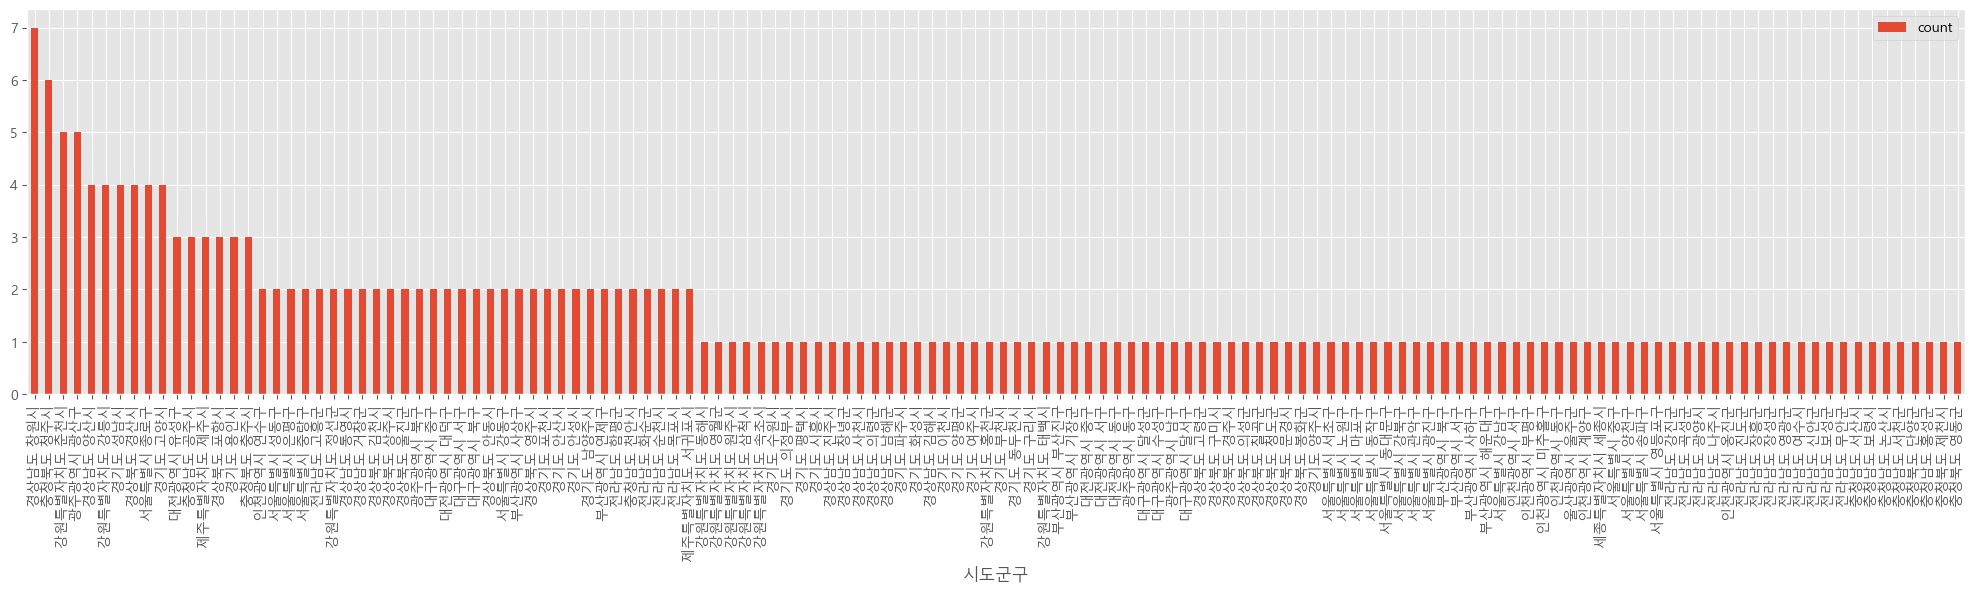

In [37]:
# 막대 그래프만 그리기. 
# 블록맵은 추가 설정이 필요해서, 다음시간에 
from matplotlib import pyplot as plt 
from matplotlib import rcParams, style
# R 프로그래밍 -> 시각화 할 때, 해당 그림의 속성을 좀더 편하게 지정하는 템플릿 
# gg -> gramar graph , 도표를 작성시 필요한 구문(문법)-> 도표, 크기, 색갈, 폰트, 등. 
style.use("ggplot")

# 폰트를 지정. font_manager
# rc -> runtime configuration , 표의 속성을 전역으로 설정하는 , 모듈 (도구)
# 한번, 표에 관련된 설정을 해두면, 밑에서 다른 도표에서 사용시, 전역으로 설정이 되었으니, 따로 할 필요가 없다.
from matplotlib import font_manager, rc 
font_name = font_manager.FontProperties(fname = "c:/Windows/Fonts/malgunbd.ttf").get_name()
rc("font", family = font_name)

# local_Hospital_Population["count"] -> 반환값 시리즈 , 시리즈(행, 열 1개로 표현을 하는 타입)
# local_Hospital_Population[["count"]] -> 반환값 데이터 프레임(표)
HS_ratio = local_Hospital_Population[["count"]]
# HS_ratio -> 타입 : DataFrame 표. 
# count 컬럼의 값들을 , 오름 차순 False -> 내림 차순, 
HS_ratio = HS_ratio.sort_values("count", ascending=False)
# 30 , 단위 인치, 
plt.rcParams["figure.figsize"] = (25,5)
# rot = 80, x 라벨의 표기의 기울기
HS_ratio.plot(kind = "bar", rot = 90)
plt.show()



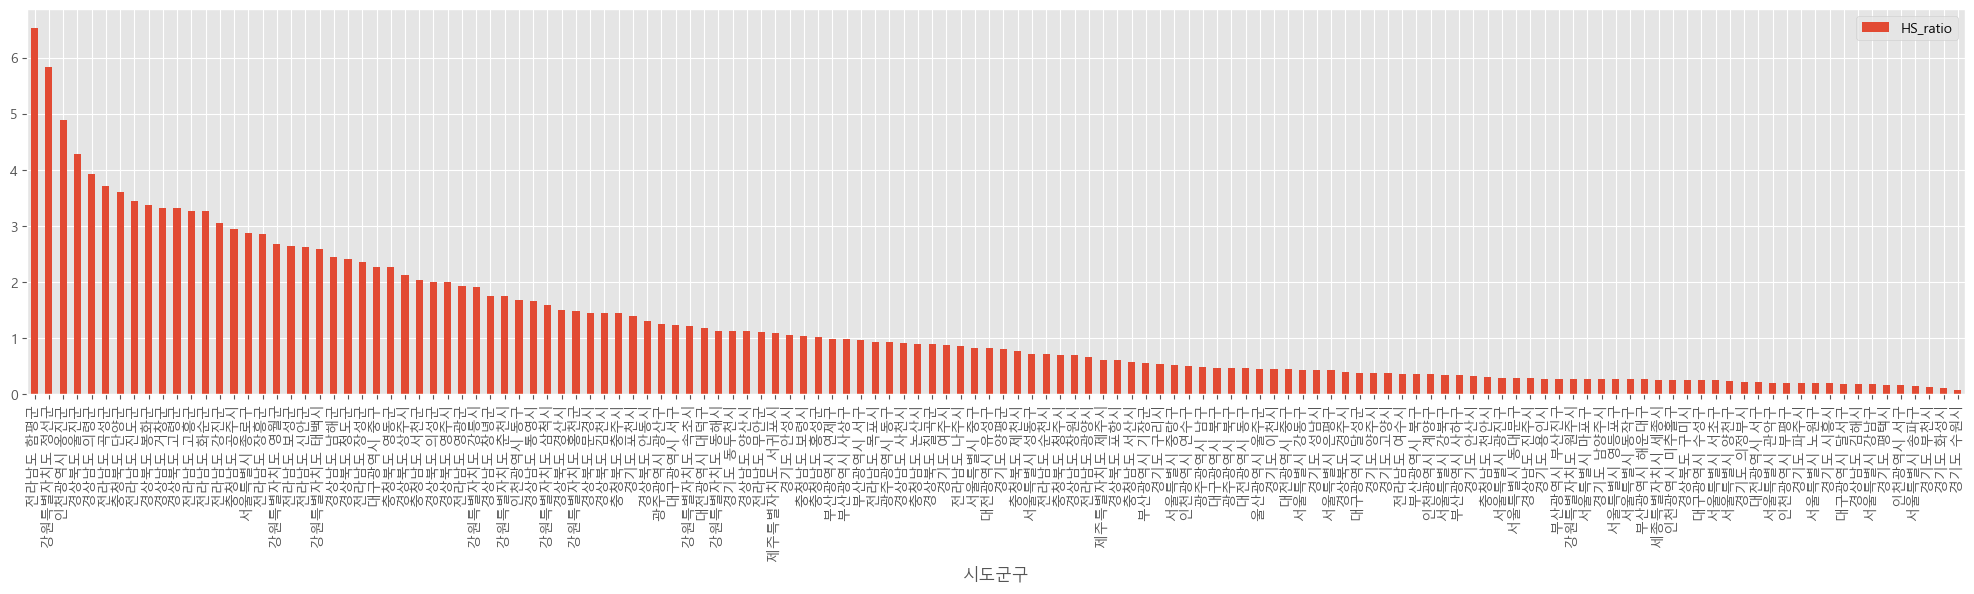

In [38]:
HS_ratio = local_Hospital_Population[["HS_ratio"]]
# HS_ratio -> 타입 : DataFrame 표. 
# count 컬럼의 값들을 , 오름 차순 False -> 내림 차순, 
HS_ratio = HS_ratio.sort_values("HS_ratio", ascending=False)
# 30 , 단위 인치, 
plt.rcParams["figure.figsize"] = (25,5)
# rot = 80, x 라벨의 표기의 기울기
HS_ratio.plot(kind = "bar", rot = 90)
plt.show()

In [21]:
# 블록맵 준비 
# 블록맵을 구성하는 , 각 지역마다, 특정의 임의의 좌표로한 데이터 가 필요.
# 블록맵을 경계를 나눌 샘플 좌표 데이터가 필요. 
# 데이터 출처를 조사, 

# 준비물 1 : data_draw_korea.csv
# 준비물 2
BORDER_LINES = [
    [(3, 2), (5, 2), (5, 3), (9, 3), (9, 1)], # 인천
    [(2, 5), (3, 5), (3, 4), (8, 4), (8, 7), (7, 7), (7, 9), (4, 9), (4, 7), (1, 7)], # 서울
    [(1, 6), (1, 9), (3, 9), (3, 10), (8, 10), (8, 9),
     (9, 9), (9, 8), (10, 8), (10, 5), (9, 5), (9, 3)], # 경기도
    [(9, 12), (9, 10), (8, 10)], # 강원도
    [(10, 5), (11, 5), (11, 4), (12, 4), (12, 5), (13, 5),
     (13, 4), (14, 4), (14, 2)], # 충청남도
    [(11, 5), (12, 5), (12, 6), (15, 6), (15, 7), (13, 7),
     (13, 8), (11, 8), (11, 9), (10, 9), (10, 8)], # 충청북도
    [(14, 4), (15, 4), (15, 6)], # 대전시
    [(14, 7), (14, 9), (13, 9), (13, 11), (13, 13)], # 경상북도
    [(14, 8), (16, 8), (16, 10), (15, 10),
     (15, 11), (14, 11), (14, 12), (13, 12)], # 대구시
    [(15, 11), (16, 11), (16, 13)], # 울산시
    [(17, 1), (17, 3), (18, 3), (18, 6), (15, 6)], # 전라북도
    [(19, 2), (19, 4), (21, 4), (21, 3), (22, 3), (22, 2), (19, 2)], # 광주시
    [(18, 5), (20, 5), (20, 6)], # 전라남도
    [(16, 9), (18, 9), (18, 8), (19, 8), (19, 9), (20, 9), (20, 10)], # 부산시
]

In [39]:
import os 
# 현재 작업 중 폴더 경로 불러오기. 
path = os.getcwd()
path


'D:\\BigDataMLVisual501\\3-test_Map_CoffeBean'

In [40]:
# 준비물 1번 메모리에 올리기. 
# index_col=0 -> 첫번째 열을 , 데이터프레임의 인덱스로 사용함.
data_draw_korea = pd.read_csv(path+"\\data_draw_korea3.csv", index_col=0, encoding="utf-8", engine="python")
data_draw_korea.head()

,인구수,shortName,x,y,면적,광역시도,행정구역
0,202520,강릉,11,4,1040.07,강원특별자치도,강릉시
1,25589,고성(강원),9,0,664.19,강원특별자치도,고성군
2,86747,동해,11,5,180.01,강원특별자치도,동해시
3,63986,삼척,11,8,1185.80,강원특별자치도,삼척시
4,76733,속초,9,1,105.25,강원특별자치도,속초시


In [41]:
#행정 구역 지역명 추출 작업. 
# 광역시도 열, 행정구역 열 추출해서, 새로운 시도군구 열을 추가하기.
data_draw_korea["시도군구"]= data_draw_korea.apply(lambda r: r["광역시도"]+ " " + r["행정구역"], axis=1)
data_draw_korea.head()

,인구수,shortName,x,y,면적,광역시도,행정구역,시도군구
0,202520,강릉,11,4,1040.07,강원특별자치도,강릉시,강원특별자치도 강릉시
1,25589,고성(강원),9,0,664.19,강원특별자치도,고성군,강원특별자치도 고성군
2,86747,동해,11,5,180.01,강원특별자치도,동해시,강원특별자치도 동해시
3,63986,삼척,11,8,1185.80,강원특별자치도,삼척시,강원특별자치도 삼척시
4,76733,속초,9,1,105.25,강원특별자치도,속초시,강원특별자치도 속초시


In [42]:
# 데이터 프레임 병합 할려면, 인덱스 동일하게 맞추는 작업(깔 맞춤)
# 시도군구 열 -> 인덱스로 설정. 
data_draw_korea = data_draw_korea.set_index("시도군구")
data_draw_korea.head()

,인구수,shortName,x,y,면적,광역시도,행정구역
시도군구,,,,,,,
강원특별자치도 강릉시,202520,강릉,11,4,1040.07,강원특별자치도,강릉시
강원특별자치도 고성군,25589,고성(강원),9,0,664.19,강원특별자치도,고성군
강원특별자치도 동해시,86747,동해,11,5,180.01,강원특별자치도,동해시
강원특별자치도 삼척시,63986,삼척,11,8,1185.80,강원특별자치도,삼척시
강원특별자치도 속초시,76733,속초,9,1,105.25,강원특별자치도,속초시


In [43]:
#data_draw_korea 의 테이블, 기존에 사용하던, local_Hospital_Population , 
# 조인 , 외부조인,-> 해당 조건에서 값이 일치 하지 않는 행까지(모두 다 합침. )
# 만약, 해당 값이 없다면 -> NaN 집계가 됨. 

data_draw_korea_local_Hospital_Population = pd.merge(data_draw_korea,local_Hospital_Population, how="outer", left_index=True, right_index=True)

data_draw_korea_local_Hospital_Population
data_draw_korea_local_Hospital_Population.head()
# data_draw_korea_local_Hospital_Population[["광역시도","행정구역"]]


,인구수_x,shortName,x,y,면적,광역시도,행정구역,시도,군구,count,인구수_y,HS_ratio
시도군구,,,,,,,,,,,,
강원특별자치도 강릉시,202520.0,강릉,11.0,4.0,1040.07,강원특별자치도,강릉시,강원특별자치도,강릉시,4.0,209625.0,1.908169
강원특별자치도 고성군,25589.0,고성(강원),9.0,0.0,664.19,강원특별자치도,고성군,NaN,NaN,NaN,NaN,NaN
강원특별자치도 동해시,86747.0,동해,11.0,5.0,180.01,강원특별자치도,동해시,강원특별자치도,동해시,1.0,88712.0,1.127243
강원특별자치도 삼척시,63986.0,삼척,11.0,8.0,1185.80,강원특별자치도,삼척시,강원특별자치도,삼척시,1.0,62819.0,1.591875
강원특별자치도 속초시,76733.0,속초,9.0,1.0,105.25,강원특별자치도,속초시,강원특별자치도,속초시,1.0,82092.0,1.218145


In [44]:
min(data_draw_korea_local_Hospital_Population["count"])

1.0

In [45]:
max(data_draw_korea_local_Hospital_Population["count"])

7.0

In [46]:
data_draw_korea_local_Hospital_Population["count"].unique()

array([ 4., nan,  1.,  2.,  5.,  3.,  7.,  6.])

In [47]:
data_draw_korea_local_Hospital_Population["HS_ratio"].unique()

array([1.90816935,        nan, 1.12724321, 1.59187507, 1.2181455 ,
       2.67766294, 0.2766489 , 5.83498658, 1.74484747, 2.58344528,
       1.48601658, 0.37206222, 0.53394844, 0.27319195, 1.12629101,
       0.12802147, 0.4353642 , 0.08352537, 0.19245796, 0.31713261,
       1.05740101, 0.37531057, 0.79922635, 0.87456163, 0.27894677,
       0.21521853, 0.44913138, 0.20089398, 0.1694384 , 1.39363111,
       0.10621473, 3.32585017, 0.18741859, 2.44798042, 0.91736386,
       1.12590424, 3.91757424, 0.29278719, 1.74886324, 0.69307068,
       1.65649304, 1.50078041, 0.40361314, 3.31301352, 0.24663649,
       1.45098921, 1.45108396, 3.36995349, 2.13001619, 1.30615657,
       1.99568931, 4.28623476, 1.99648618, 2.41773652, 0.90186777,
       0.60859828, 1.25892578, 0.4762381 , 0.93314048, 0.47375515,
       0.18900555, 0.38132572, 0.47509098, 1.22678313, 0.24569783,
       2.27277893, 1.17587573, 0.45863775, 0.21496916, 0.81901423,
       0.44741528, 0.55879033, 0.27800018, 0.36486763, 0.98454

In [48]:
# 준비물 2번 -> 지도에 , 각 2차지역을 사각형(블록)을 나누는 경계선 좌표.
BORDER_LINES = [
    [(3, 2), (5, 2), (5, 3), (9, 3), (9, 1)], # 인천
    [(2, 5), (3, 5), (3, 4), (8, 4), (8, 7), (7, 7), (7, 9), (4, 9), (4, 7), (1, 7)], # 서울
    [(1, 6), (1, 9), (3, 9), (3, 10), (8, 10), (8, 9),
     (9, 9), (9, 8), (10, 8), (10, 5), (9, 5), (9, 3)], # 경기도
    [(9, 12), (9, 10), (8, 10)], # 강원도
    [(10, 5), (11, 5), (11, 4), (12, 4), (12, 5), (13, 5),
     (13, 4), (14, 4), (14, 2)], # 충청남도
    [(11, 5), (12, 5), (12, 6), (15, 6), (15, 7), (13, 7),
     (13, 8), (11, 8), (11, 9), (10, 9), (10, 8)], # 충청북도
    [(14, 4), (15, 4), (15, 6)], # 대전시
    [(14, 7), (14, 9), (13, 9), (13, 11), (13, 13)], # 경상북도
    [(14, 8), (16, 8), (16, 10), (15, 10),
     (15, 11), (14, 11), (14, 12), (13, 12)], # 대구시
    [(15, 11), (16, 11), (16, 13)], # 울산시
    [(17, 1), (17, 3), (18, 3), (18, 6), (15, 6)], # 전라북도
    [(19, 2), (19, 4), (21, 4), (21, 3), (22, 3), (22, 2), (19, 2)], # 광주시
    [(18, 5), (20, 5), (20, 6)], # 전라남도
    [(16, 9), (18, 9), (18, 8), (19, 8), (19, 9), (20, 9), (20, 10)], # 부산시
]

In [51]:
# 힘든 작업, 블록 맵을 그리기 위한 함수를 설정.
# 이미 만들어진 함수를 재사용. 
# blockedMap : 원본 데이터 프레임, 
# ex) data_draw_korea_local_Hospital_Population : 외부 조인한 원본 데이터 
# targetData : 내가 찾고자하는 결과데이터(종속변수)
# 예) 의료기관의 수 : count , 인구수 대비 의료기관의 비율 :  HS_ratio
# title, color : 도표의 제목과, 색깔. 

def draw_blockMap(blockedMap, targetData, title, color):
  # 블록맥의 각 구역의 색깔을 지정시, 최소 비율 -> 흰색 가까운 임의의 비율 색. 
  # 히트맵에서, 연관관계 가 높으면 색깔이 진한색(빨간,파란)
  whitelabelmin = (max(blockedMap[targetData])- min(blockedMap[targetData])) * 0.25 + min(blockedMap[targetData])
  # test 샘플값 
  # print(f"whitelabelmin 전 : {whitelabelmin}")
  # whitelabelmin = 2.5
  # print(f"whitelabelmin 후 : {whitelabelmin}")

  # 라벨 이름 
  datalabel = targetData  

  # vmin , vmax , -> 색깔을 표현하기 위한 최소, 최대 값으로 활용할 예정. 
  vmin = min(blockedMap[targetData])
  # print(f"vmin 전 : {vmin}")
  # vmin = 1.0
  print(f"vmin 후 : {vmin}")
  vmax = max(blockedMap[targetData])
  # print(f"vmax 전 : {vmax}")
  # vmax = 7.0
  print(f"vmax 후 : {vmax}")

  # pivot 함수를 이용해서, 기존의 행과 열을 , 새로운 데이터프레임(테이블)로 재배치하는 함수. 
  # index = "y" : 행, columns = "x" : 열 , 그 안에 값으로 : targetData
  mapdata = blockedMap.pivot(index='y', columns='x', values=targetData)
  print(f"mapdata : {mapdata}")

  # 전처리, NaN 없애기. 
  # np.ma.masked_where(각데이터의 NaN의 존재여부 True False 판단, mapdata)
  # np.isnan(mapdata) -> pivot 라는 함수로 새롭게 만들어진 테이블에서, nan 다 조사해서, 
  # 그 결과를 True, False 로 다반환, 
  # masked_mapdata -> nan 다 제거된 테이블 .
  masked_mapdata = np.ma.masked_where(np.isnan(mapdata),mapdata)
  print(f"masked_mapdata : {masked_mapdata}")

  # 그래프 옵션 
  # 8 인치, 13인치. 
  plt.figure(figsize=(8,13))
  # 제목은 함수의 인자값으로 들어고 됨. 
  plt.title(title)
  
  # 그래프 색깔. cmap = color -> 인자값으로 받을 예정, 빨간, 파란 
  # 블록맵의 각 사각형의 색깔을 지정하는 로직. 
  plt.pcolor(masked_mapdata, vmin = vmin , vmax = vmax , cmap = color, edgecolor = "#aaaaaa", linewidth = 0.5)

  #지역 이름표시. 
  # 원본 데이터를 반복문을 전체 조회를 해서, 각 지역명을 표기하는 방식
  # idx : 각 행의 인덱스, row : 각 행 
  for idx, row in blockedMap.iterrows():
    # 지도에 표시되는 지역명, 주석처리 사용이됨, 옵션 설정. 
    # print(row["광역시도"].endswith("시"))
    annocolr = "white" if row[targetData] > whitelabelmin else "black"

    # 광역시 = 시도, 행정구역 = 군구, 
    # 부산 강서구, 서울 강서구, 
    # 부산 동구, 서울, 인천 , 동구, 서구 , 중구 , 겹침. 
    # 2차지역명으로 만 표기시 중복이 되므로, 1차 지역명과 같이 표기 하는 방법. 

   
    # 부산
    # 서구
    # row["광역시도"][:2], 2 끝 미포함 , 0,1 ex) 부산광역시 -> 부산
    # row["행정구역"][:-1], -1 맨마지막 의미 미포함, 맨마지막 한글자 제외하고 전부
    #  ex) 강릉시 ->  강릉 
    # row["행정구역"][-1], 마지막 글자를 의미함. 
    #  ex) 강릉시 ->  시
    # ex) 부산광역시 , 
    if isinstance(row["광역시도"], str) and row["광역시도"].endswith("시") and not row["광역시도"].startswith("세종"):
         dispname = "{}\n{}".format(row["광역시도"][:2], row["행정구역"][:-1])
         print(f"dispname_1 : {dispname}")
         if isinstance(row["행정구역"], str) and len(row["행정구역"]) <= 2:
            dispname += row["행정구역"][-1]
            print(f"dispname_2 : {dispname}")
    elif isinstance(row["행정구역"], str):
        dispname = row["행정구역"][:-1]
        print(f"dispname_3 : {dispname}")
    else:
        dispname = ''  # 행정구역이 문자열이 아닐 때 기본값 설정
        print(f"dispname_4 : {dispname}")

# 글자 크기 조정하기. 2글자 조금 크게, 3글자 조금 작게 조정하기.
    if dispname:  # dispname이 빈 문자열이 아닌 경우에만 진행
        last_line = dispname.splitlines()[-1]
        if len(last_line) >= 3:
            fontsize, linespacing = 9.5, 1.5
        else:
            fontsize, linespacing = 11, 1.2
    else:
        fontsize, linespacing = 11, 1.2  # 기본값 설정

    # 주석의 위치 조정 하기. 폰트 크기, 색 설정., 굵기 등.  
    plt.annotate(dispname, (row["x"]+0.5, row["y"]+0.5), weight = "bold",fontsize=fontsize, ha="center", va="center", color = annocolr, linespacing=linespacing)

  # 라인의 경계 그리기, 
  for path in BORDER_LINES:
    # zip, 같은 인덱스 끼리 묶기, 
    # *path, 언패킹, 각각의 변수에 할당. 
    ys, xs = zip(*path)
    plt.plot(xs,ys, c = "black", lw=4)
  # gca, get current axe , 현재 축을 선택.
  # y 축 반전하는 함수, invert_yaxis() -> 예) 원래 y로 위로 갈수록 커지는 속성 기본.
  # 반전, y가 커질수로, 아래로 향하게 하는 속성. 
  plt.gca().invert_yaxis()
  # x축, y축 표기 여부
  plt.axis("off")
  # 그래프 오른쪽의 각 색깔별 막대 그래프, shrink 크기, aspect 종횡비율, 각구간 범위.
  cb = plt.colorbar(shrink =1 , aspect = 10)
  #
  cb.set_label(datalabel)

  # 내부 요소가 겹치지 않게 그리기. 
  plt.tight_layout()
  # 결과 화면, 이미지 파일로 저장하기. 
  plt.savefig("./blockMap_"+ targetData + ".png")
  plt.show 




vmin 후 : 1.0
vmax 후 : 7.0
mapdata : x     NaN   0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   10.0  \
y                                                                              
NaN    1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
0.0    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1.0    NaN   NaN   NaN   NaN   NaN   NaN   NaN   1.0   NaN   2.0   1.0   NaN   
2.0    NaN   NaN   NaN   NaN   1.0   4.0   1.0   NaN   1.0   1.0   NaN   NaN   
3.0    NaN   NaN   NaN   NaN   NaN   2.0   NaN   4.0   1.0   2.0   NaN   5.0   
4.0    NaN   NaN   1.0   1.0   NaN   NaN   1.0   1.0   1.0   2.0   1.0   1.0   
5.0    NaN   NaN   1.0   1.0   1.0   1.0   1.0   NaN   2.0   2.0   NaN   NaN   
6.0    NaN   NaN   NaN   1.0   2.0   1.0   1.0   1.0   1.0   1.0   1.0   NaN   
7.0    NaN   NaN   NaN   NaN   1.0   NaN   NaN   1.0   NaN   NaN   1.0   1.0   
8.0    NaN   1.0   2.0   NaN   NaN   2.0   NaN   NaN   4.0   1.0   1.0   1.0   
9.0 

C:\Users\it\AppData\Local\Temp\ipykernel_7356\1457806840.py:115: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = plt.colorbar(shrink =1 , aspect = 10)


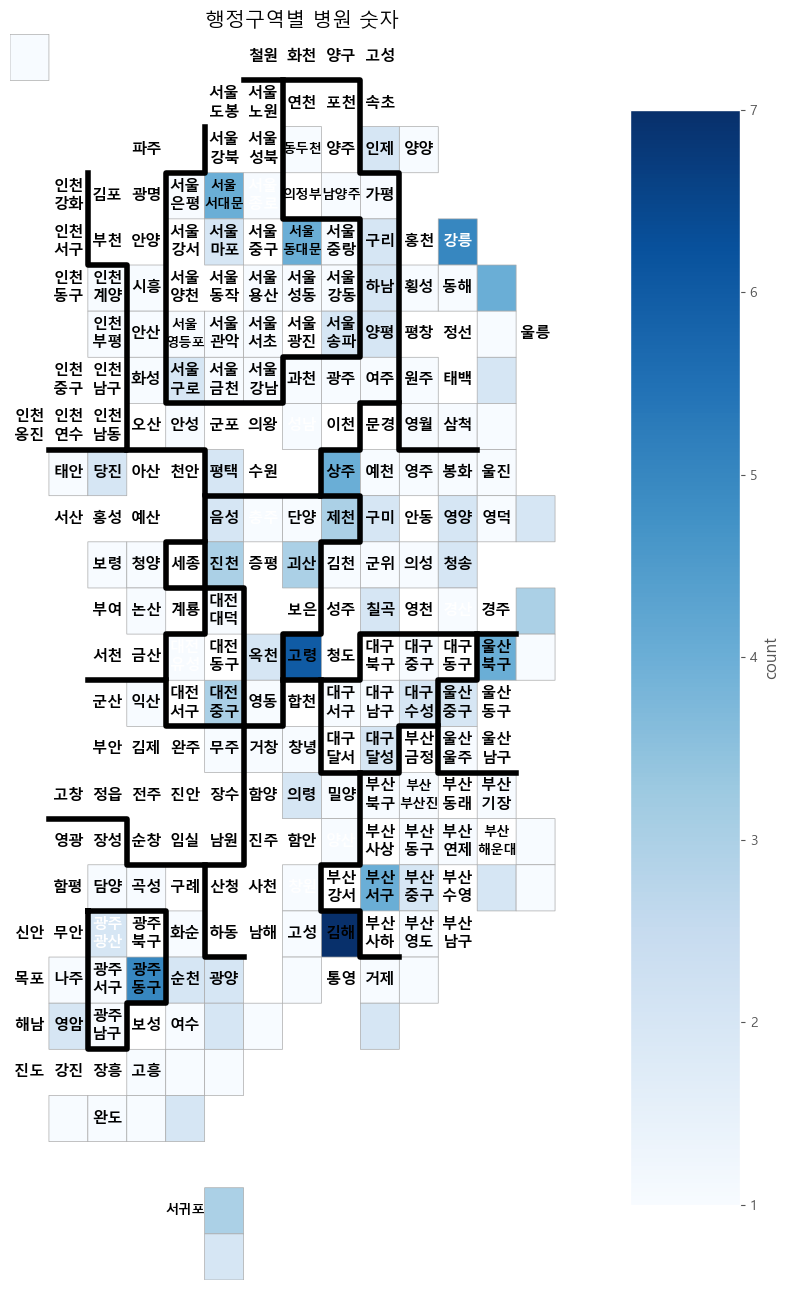

In [52]:
# 함수 이용해서 블록맵 그려보기. 
draw_blockMap(data_draw_korea_local_Hospital_Population,"count","행정구역별 병원 숫자", "Blues")

whitelabelmin 전 : 2.818679747286397
whitelabelmin 후 : 2.5
vmin 전 : 0.0835253720846513
vmin 후 : 1.0
vmax 전 : 11.024142872891634
vmax 후 : 7.0
mapdata : x         0         1         2         3         4         5         6   \
y                                                                          
0        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1        NaN       NaN       NaN       NaN       NaN       NaN  0.200410   
2        NaN       NaN       NaN  0.200894  0.372062  0.346338       NaN   
3        NaN       NaN       NaN       NaN  0.428295       NaN  2.867445   
4        NaN  0.160448  0.128021       NaN       NaN       NaN  0.824878   
5        NaN  1.675182  0.355792  0.192458  0.229108  0.263723       NaN   
6        NaN       NaN  0.203708  0.317133       NaN       NaN  0.245039   
7        NaN       NaN       NaN  0.106215       NaN       NaN  0.369597   
8   4.892847  0.510290       NaN       NaN  0.528701       NaN       NaN   
9        NaN  

C:\Users\it\AppData\Local\Temp\ipykernel_6240\1274076659.py:104: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = plt.colorbar(shrink =1 , aspect = 10)


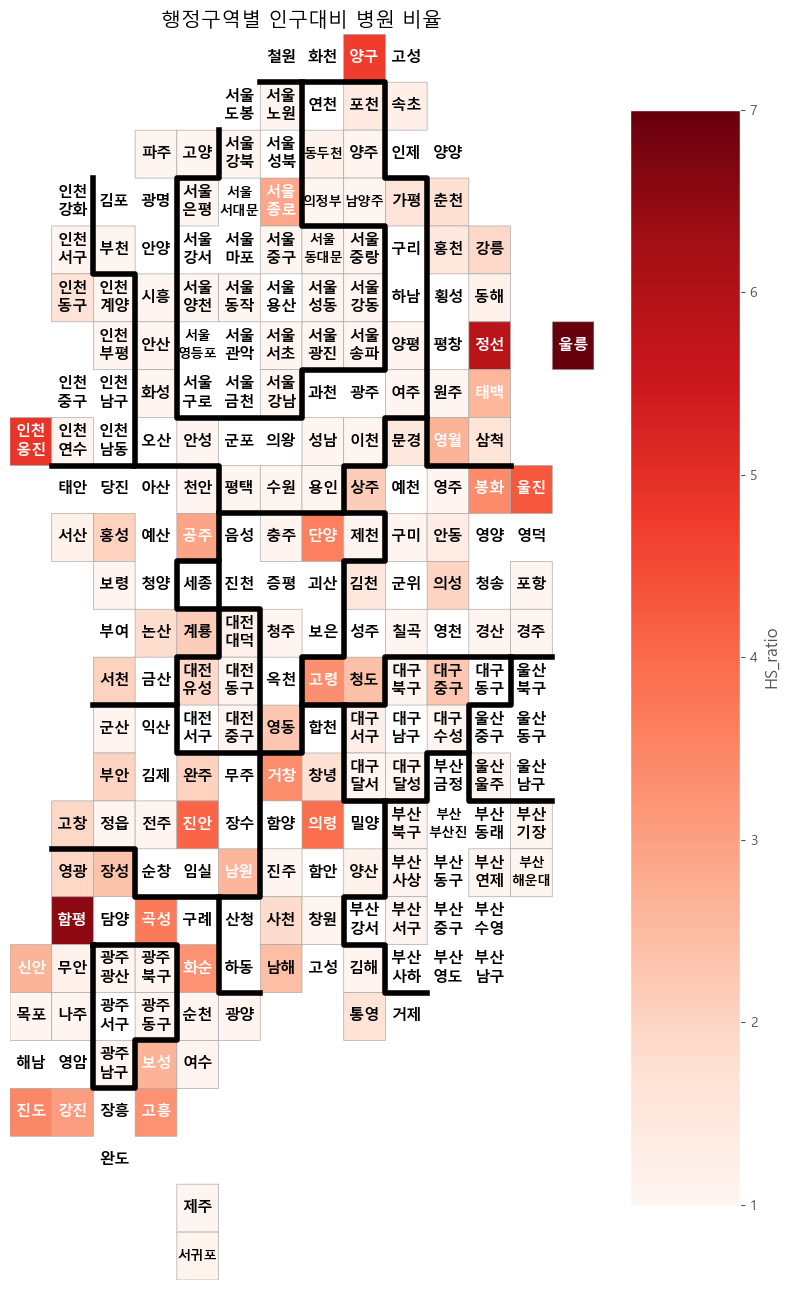

In [34]:
# 함수 이용해서 블록맵 그려보기. 
draw_blockMap(data_draw_korea_local_Hospital_Population,"HS_ratio","행정구역별 인구대비 병원 비율", "Reds")